# Notebook: Data validation

Sensor data quality plays a vital role in Internet of Things (IoT) applications as they are rendered useless if the data quality is bad.

The second most commonly found error in sensor data is missing data. missing data is caused by various factors such as unstable wireless connection due to network congestion, sensor device outages due to its limited battery life, environmental interferences e.g. human blockage, walls, and weather conditions, and malicious attacks. There are cases where sensor data is missing for extended periods of time, which might lead to incorrect decision making on the consumer side. 


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import seaborn as sbn
sbn.set_theme()

## Load the PHMDataset2018 dataset

In [3]:
from ceruleo.dataset.catalog.PHMDataset2018 import PHMDataset2018, FailureType

/home/luciano/venvs/ceruleo/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-02-23 21:02:29.344194: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-23 21:02:29.345851: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-23 21:02:29.374001: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-23 21:02:29.374029: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607

In [4]:
dataset = PHMDataset2018(
    tools=['01M01', '04M01']
)

### Create a transformer for a dataset

In [5]:
from ceruleo.dataset.analysis.numerical_features import analysis
from ceruleo.transformation.functional.transformers import Transformer
from ceruleo.transformation.features.selection import ByNameFeatureSelector, ByTypeFeatureSelector
from ceruleo.iterators.iterators import RelativeToEnd
from ceruleo.transformation.features.slicing import SliceRows
from ceruleo.transformation.functional.pipeline.pipeline import make_pipeline
from ceruleo.transformation.features.resamplers import IndexMeanResampler
from ceruleo.transformation.features.transformation import Clip
from ceruleo.transformation.features.slicing import SliceRows
from ceruleo.iterators.iterators import RelativeToEnd

In [6]:
from ceruleo.transformation.features.cast import ToDateTime


FEATURES = [
   'IONGAUGEPRESSURE', 'ETCHBEAMVOLTAGE', 'ETCHBEAMCURRENT',
   'ETCHSUPPRESSORVOLTAGE', 'ETCHSUPPRESSORCURRENT', 'FLOWCOOLFLOWRATE',
   'FLOWCOOLPRESSURE', 'ETCHGASCHANNEL1READBACK', 'ETCHPBNGASREADBACK',
]
transformer = Transformer(
    pipelineX=make_pipeline(
        ToDateTime(index=True),
        ByNameFeatureSelector(features=FEATURES), 
        Clip(lower=-6, upper=6),
        IndexMeanResampler(rule='120s'),
        SliceRows(initial=RelativeToEnd(1500))
    ), 
    pipelineY=make_pipeline(
        ToDateTime(index=True),
        ByNameFeatureSelector(features=['RUL']),  
        IndexMeanResampler(rule='120s'),
        SliceRows(initial=RelativeToEnd(1500))
    )
)

transformed_dataset = transformer.fit_map(dataset)

(array([ 3.,  0.,  1.,  0.,  0.,  3.,  0.,  0.,  1., 16.]),
 array([   5. ,  154.5,  304. ,  453.5,  603. ,  752.5,  902. , 1051.5,
        1201. , 1350.5, 1500. ]),
 <BarContainer object of 10 artists>)

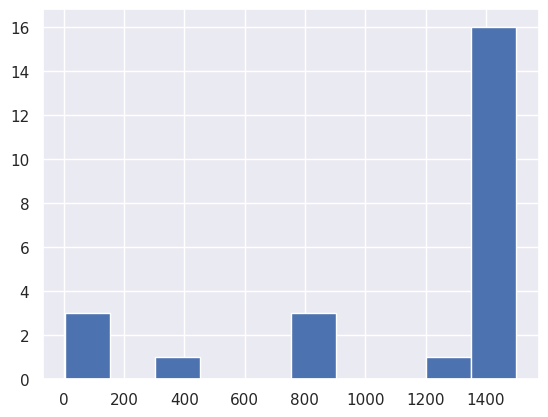

In [7]:
plt.hist([life[0].shape[0] for life in transformed_dataset])

## Sample rate

We can evalute the sample rate of the dataset without transformation. We can see that there are huge variations of the sample rate, but the vast majority of points are sampled after 4 seconds.

In [8]:
from ceruleo.dataset.analysis.sample_rate import sample_rate, sample_rate_summary

(0.0, 10.0)

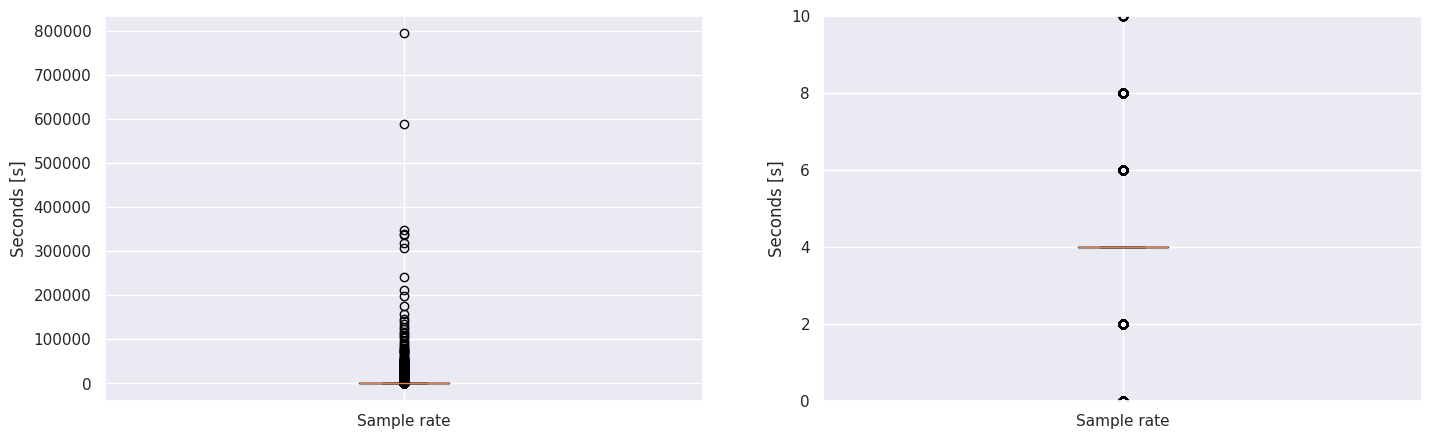

In [9]:
sample_rates = sample_rate(dataset)
fig, ax = plt.subplots(1, 2, figsize=(17, 5))
ax[0].boxplot(sample_rates, labels=['Sample rate'])
ax[0].set_ylabel('Seconds [s]')

ax[1].boxplot(sample_rates, labels=['Sample rate'])
ax[1].set_ylabel('Seconds [s]')
ax[1].set_ylim(0, 10)

In [10]:
sample_rate_summary(dataset)

,Mean sample rate,Std sample rate,Mode sample rate
Dataset,10.105973,607.552008,4


## Missing values
Usually, the information of sensors is incomplete and this causes numerous missing values in the features. This library provides some useful functions to analyse the proportion of the missing values for each feature for each life. In some cases, if the feature values are missing in multiple lives, that feature can be discarded.

In [11]:
analysis(transformed_dataset, what_to_compute=['null'])

,null Mean,null Max,null Min
IONGAUGEPRESSURE,0.0+/-0,0.0,0.0
ETCHBEAMVOLTAGE,0.0+/-0,0.0,0.0
ETCHBEAMCURRENT,0.0+/-0,0.0,0.0
ETCHSUPPRESSORVOLTAGE,0.0+/-0,0.0,0.0
ETCHSUPPRESSORCURRENT,0.0+/-0,0.0,0.0
FLOWCOOLFLOWRATE,0.0+/-0,0.0,0.0
FLOWCOOLPRESSURE,0.0+/-0,0.0,0.0
ETCHGASCHANNEL1READBACK,0.0+/-0,0.0,0.0
ETCHPBNGASREADBACK,0.0+/-0,0.0,0.0


## Pairwise correlation

In [12]:
from ceruleo.dataset.analysis.correlation import correlation_analysis

In [13]:
(correlation_analysis(transformed_dataset, corr_threshold=0.7)
 .sort_values(by='Abs mean correlation', ascending=False)
 .head(15)
)

Mean Correlation  \
Feature 1               Feature 2                                   
ETCHBEAMCURRENT         ETCHSUPPRESSORCURRENT            0.991699   
                        ETCHBEAMVOLTAGE                  0.988537   
ETCHGASCHANNEL1READBACK IONGAUGEPRESSURE                 0.988268   
                        ETCHPBNGASREADBACK               0.983862   
ETCHPBNGASREADBACK      IONGAUGEPRESSURE                 0.983569   
ETCHBEAMVOLTAGE         ETCHSUPPRESSORCURRENT            0.981086   
ETCHPBNGASREADBACK      FLOWCOOLFLOWRATE                 0.977637   
ETCHGASCHANNEL1READBACK FLOWCOOLFLOWRATE                 0.969433   
FLOWCOOLFLOWRATE        IONGAUGEPRESSURE                 0.954625   
ETCHSUPPRESSORCURRENT   IONGAUGEPRESSURE                 0.944165   
ETCHBEAMCURRENT         IONGAUGEPRESSURE                 0.940549   
ETCHGASCHANNEL1READBACK ETCHSUPPRESSORCURRENT            0.939134   
ETCHBEAMCURRENT         ETCHGASCHANNEL1READBACK          0.936466   
ETCHBEAMVOLTAGE         ETCHGASCHANNEL1READBACK          0.929428   
ETCHPBNGASREADBACK      ETCHSUPPRESSORVOLTAGE            0.923903   

                                                 Std Correlation  \
Feature 1               Feature 2                                  
ETCHBEAMCURRENT         ETCHSUPPRESSORCURRENT           0.019339   
                        ETCHBEAMVOLTAGE                 0.006507   
ETCHGASCHANNEL1READBACK IONGAUGEPRESSURE                0.014376   
                        ETCHPBNGASREADBACK              0.009440   
ETCHPBNGASREADBACK      IONGAUGEPRESSURE                0.015495   
ETCHBEAMVOLTAGE         ETCHSUPPRESSORCURRENT           0.018304   
ETCHPBNGASREADBACK      FLOWCOOLFLOWRATE                0.010261   
ETCHGASCHANNEL1READBACK FLOWCOOLFLOWRATE                0.013474   
FLOWCOOLFLOWRATE        IONGAUGEPRESSURE                0.015559   
ETCHSUPPRESSORCURRENT   IONGAUGEPRESSURE                0.025810   
ETCHBEAMCURRENT         IONGAUGEPRESSURE                0.039555   
ETCHGASCHANNEL1READBACK ETCHSUPPRESSORCURRENT           0.031115   
ETCHBEAMCURRENT         ETCHGASCHANNEL1READBACK         0.045939   
ETCHBEAMVOLTAGE         ETCHGASCHANNEL1READBACK         0.048063   
ETCHPBNGASREADBACK      ETCHSUPPRESSORVOLTAGE           0.069885   

                                                 Percentage of lives with a high correlation  \
Feature 1               Feature 2                                                              
ETCHBEAMCURRENT         ETCHSUPPRESSORCURRENT                                     100.000000   
                        ETCHBEAMVOLTAGE                                           100.000000   
ETCHGASCHANNEL1READBACK IONGAUGEPRESSURE                                          100.000000   
                        ETCHPBNGASREADBACK                                        100.000000   
ETCHPBNGASREADBACK      IONGAUGEPRESSURE                                          100.000000   
ETCHBEAMVOLTAGE         ETCHSUPPRESSORCURRENT                                     100.000000   
ETCHPBNGASREADBACK      FLOWCOOLFLOWRATE                                          100.000000   
ETCHGASCHANNEL1READBACK FLOWCOOLFLOWRATE                                          100.000000   
FLOWCOOLFLOWRATE        IONGAUGEPRESSURE                                          100.000000   
ETCHSUPPRESSORCURRENT   IONGAUGEPRESSURE                                          100.000000   
ETCHBEAMCURRENT         IONGAUGEPRESSURE                                          100.000000   
ETCHGASCHANNEL1READBACK ETCHSUPPRESSORCURRENT                                     100.000000   
ETCHBEAMCURRENT         ETCHGASCHANNEL1READBACK                                   100.000000   
ETCHBEAMVOLTAGE         ETCHGASCHANNEL1READBACK                                   100.000000   
ETCHPBNGASREADBACK      ETCHSUPPRESSORVOLTAGE                                      95.833333   

                                                 Abs mean correlation  \
Feature 1   

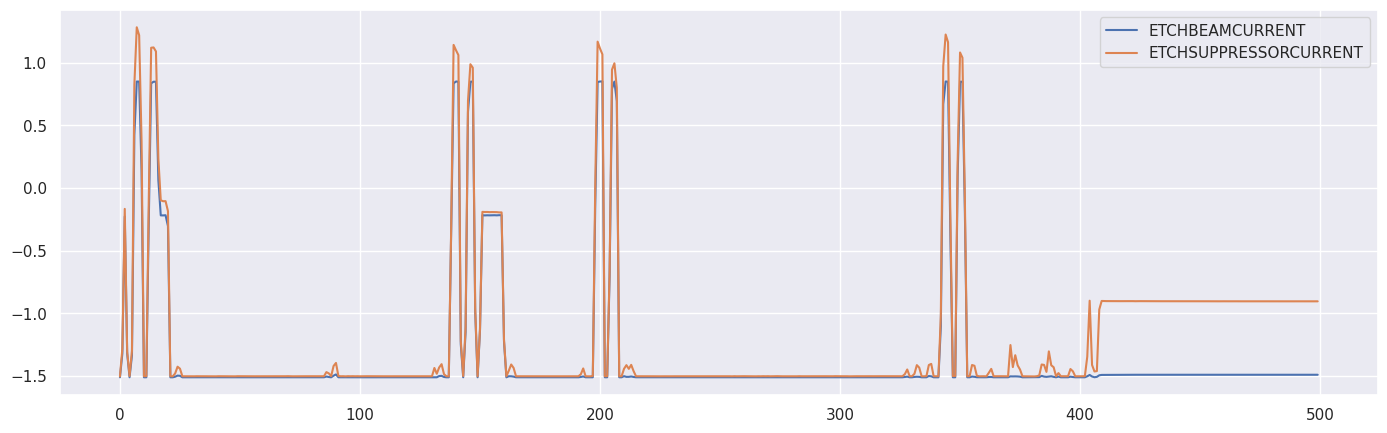

In [14]:
fig, ax = plt.subplots(figsize=(17, 5))
ax.plot(transformed_dataset.get_features_of_life(0)['ETCHBEAMCURRENT'].values[-500:],
        label='ETCHBEAMCURRENT')
ax.plot(transformed_dataset.get_features_of_life(0)['ETCHSUPPRESSORCURRENT'].values[-500:], 
        label='ETCHSUPPRESSORCURRENT')
ax.legend()

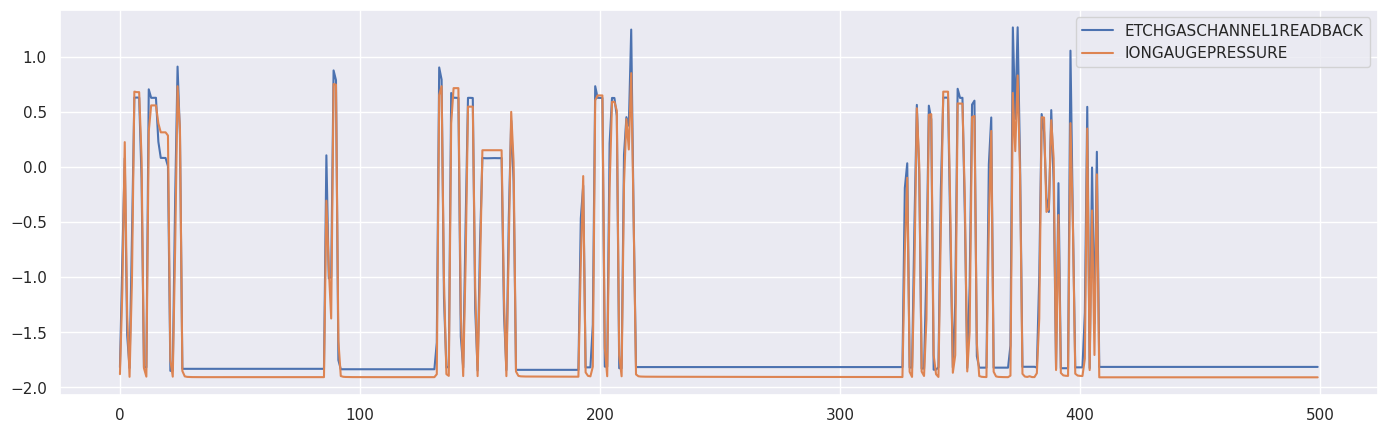

In [15]:
fig, ax = plt.subplots(figsize=(17, 5))
ax.plot(transformed_dataset.get_features_of_life(0)['ETCHGASCHANNEL1READBACK'].values[-500:],
        label='ETCHGASCHANNEL1READBACK')
ax.plot(transformed_dataset.get_features_of_life(0)['IONGAUGEPRESSURE'].values[-500:], 
        label='IONGAUGEPRESSURE')
ax.legend()

## Feature distribution

In [16]:
from ceruleo.dataset.analysis.distribution import features_divergeces

In [17]:

d = features_divergeces(transformed_dataset)

In [18]:
d.sort_values(by='KL', ascending=False).head(15)

,Life 1,Life 2,W,KL,feature
632,3,18,0.050756,7.640330,ETCHGASCHANNEL1READBACK
80,3,18,0.050756,7.640330,ETCHBEAMCURRENT
1460,3,18,0.050756,7.640330,ETCHSUPPRESSORVOLTAGE
908,3,18,0.050756,7.640330,ETCHPBNGASREADBACK
669,5,18,0.046203,7.634295,ETCHGASCHANNEL1READBACK
117,5,18,0.059211,7.534350,ETCHBEAMCURRENT
1184,3,18,0.050756,6.919034,ETCHSUPPRESSORCURRENT
356,3,18,0.050756,6.919034,ETCHBEAMVOLTAGE
2275,3,5,0.020163,6.014399,IONGAUGEPRESSURE
1736,3,18,0.050756,5.346047,FLOWCOOLFLOWRATE


In [19]:
def plot_distributions(ax, ds, life1, life2, feature):
    ax.hist(ds.get_features_of_life(life1)[feature],
        label=feature,
        density=True,
        alpha=0.5,
        bins=20)
    ax.hist(ds.get_features_of_life(life2)[feature], 
            label=feature,
            density=True,
            alpha=0.5,
            bins=20)
    ax.legend()
    
    
def plot_timeseries(ax, ds, life, feature):
    ax.plot(ds.get_features_of_life(life)[feature].values,
            alpha=0.5,
            label=feature)




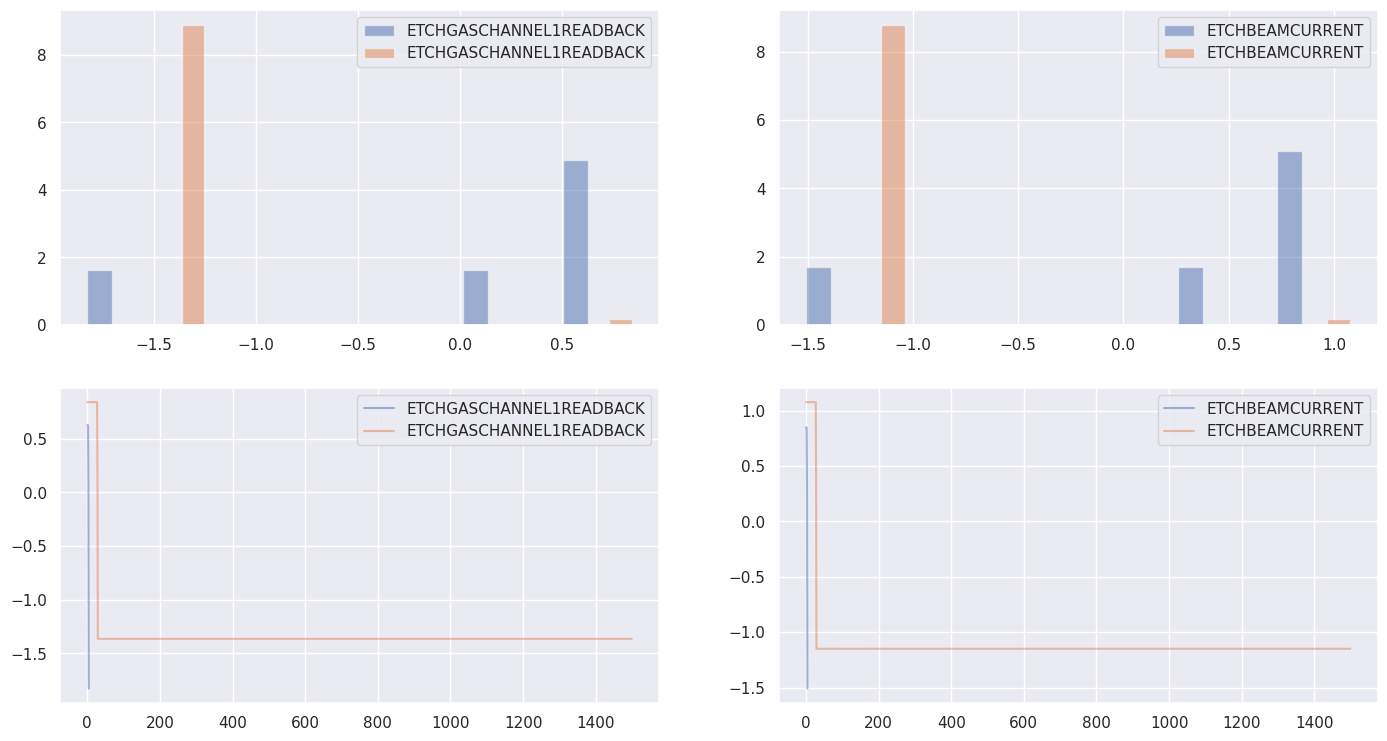

In [20]:
first_row = d.sort_values(by='KL', ascending=False).iloc[0, :]
feature = first_row['feature']
life1 = first_row['Life 1']
life2 = first_row['Life 2']
fig, ax = plt.subplots(2, 2, figsize=(17, 9))
plot_distributions(ax[0, 0], transformed_dataset, life1, life2, feature)

plot_timeseries(ax[1, 0], transformed_dataset, life1, feature )
plot_timeseries(ax[1, 0], transformed_dataset, life2, feature )
ax[1, 0].legend()


first_row = d.sort_values(by='KL', ascending=False).iloc[1, :]
feature = first_row['feature']
life1 = first_row['Life 1']
life2 = first_row['Life 2']
plot_distributions(ax[0, 1], transformed_dataset, life1, life2, feature)


plot_timeseries(ax[1, 1], transformed_dataset, life1, feature )
plot_timeseries(ax[1, 1], transformed_dataset, life2, feature )
ax[1, 1].legend()

In [21]:
d.sort_values(by='W', ascending=False).head(5)

,Life 1,Life 2,W,KL,feature
1296,10,18,0.098572,2.682223,ETCHSUPPRESSORCURRENT
1238,6,18,0.096356,2.976255,ETCHSUPPRESSORCURRENT
2473,18,23,0.095022,1.127008,IONGAUGEPRESSURE
2268,2,18,0.093752,2.443263,IONGAUGEPRESSURE
1143,1,18,0.093333,2.650474,ETCHSUPPRESSORCURRENT


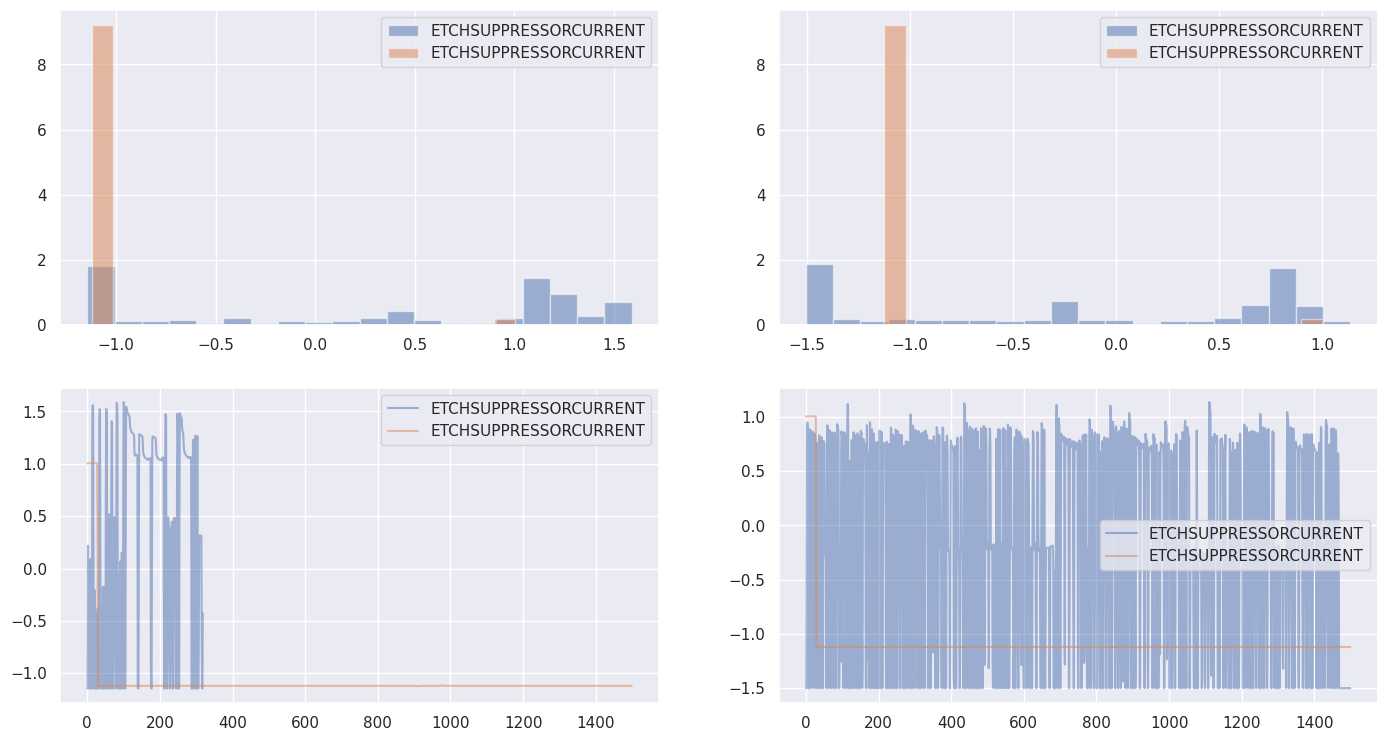

In [22]:
first_row = d.sort_values(by='W', ascending=False).iloc[0, :]
feature = first_row['feature']
life1 = first_row['Life 1']
life2 = first_row['Life 2']
fig, ax = plt.subplots(2, 2, figsize=(17, 9))
plot_distributions(ax[0, 0], transformed_dataset, life1, life2, feature)

plot_timeseries(ax[1, 0], transformed_dataset, life1, feature )
plot_timeseries(ax[1, 0], transformed_dataset, life2, feature )
ax[1, 0].legend()


first_row = d.sort_values(by='W', ascending=False).iloc[1, :]
feature = first_row['feature']
life1 = first_row['Life 1']
life2 = first_row['Life 2']
plot_distributions(ax[0, 1], transformed_dataset, life1, life2, feature)


plot_timeseries(ax[1, 1], transformed_dataset, life1, feature )
plot_timeseries(ax[1, 1], transformed_dataset, life2, feature )
ax[1, 1].legend()